## Comparing KGs to real-world complex networks

Using three temporal instant KGs from the temporal KGen-generated *ISWC* TKG as target

# Environment Setup

Install & imports

In [ ]:
# Install required packages
import sys
!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.7 MB/s eta 0:00:00


Auxiliary functions

In [ ]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))

    Ref.: https://stackoverflow.com/a/62662992
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

rdfs = {'2019': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2019/merged_kg.ttl',
        '2020': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2020/merged_kg.ttl',
        '2021': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2021/merged_kg.ttl'}

## Loading RDF model

Pointing to a remote Turtle (*.ttl) file.

In [ ]:
rgs = dict()
for i in rdfs.keys():
    rg = RDFGraph()
    rg.parse(rdfs[i], format='ttl') # Turtle format

    print("rdflib Graph {} loaded successfully with {} triples".format(i, len(rg)))
    rgs[i] = rg

rdflib Graph 2019 loaded successfully with 24984 triples
rdflib Graph 2020 loaded successfully with 21147 triples
rdflib Graph 2021 loaded successfully with 15672 triples


## Converting rdflib.Graph to networkx.MultiDiGraph

KGs are directed graphs with the possibility of multiple paralell edges.

In [ ]:
TKG = dict()
for i in rgs:
    # Conversion of rdflib.Graph to networkx.MultiDiGraph
    KG = rdflib_to_networkx_multidigraph(rgs[i])
    print("networkx Graph loaded successfully with length {}".format(len(KG)))

    TKG[i] = KG

networkx Graph loaded successfully with length 12285
networkx Graph loaded successfully with length 10618
networkx Graph loaded successfully with length 8003


# General Network Metrics

Network size and density

In [ ]:
for i in TKG:
    # Network size
    print(f"NETWORK {i} SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(TKG[i].number_of_nodes(), TKG[i].number_of_edges()))
    print()

    # Density
    print(f"NETWORK {i} DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(TKG[i])))
    print()

NETWORK 2019 SIZE
The network has 12285 nodes and 24984 edges

NETWORK 2019 DENSITY
The network density is 0.00016555679206281616

NETWORK 2020 SIZE
The network has 10618 nodes and 21147 edges

NETWORK 2020 DENSITY
The network density is 0.00018758764313437477

NETWORK 2021 SIZE
The network has 8003 nodes and 15672 edges

NETWORK 2021 DENSITY
The network density is 0.0002447220257911906



# Scale-free Networks

In-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

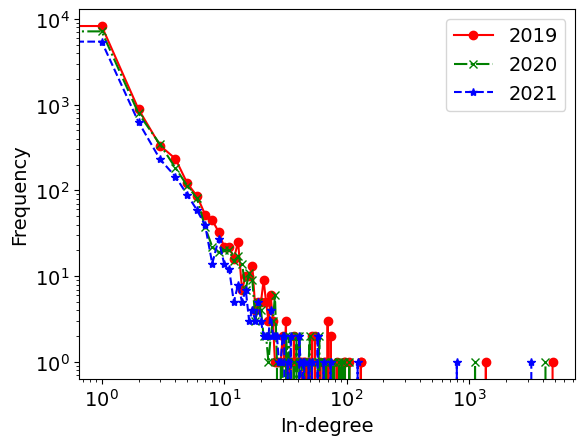

In [ ]:
styles = {'2019': 'ro-',
          '2020': 'gx-.',
          '2021': 'b*--'}
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], in_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, styles[i], label=i)
plt.legend(loc="upper right")
plt.xlabel('In-degree')
plt.ylabel('Frequency')

Out-degree distribution

Text(0, 0.5, 'Frequency')

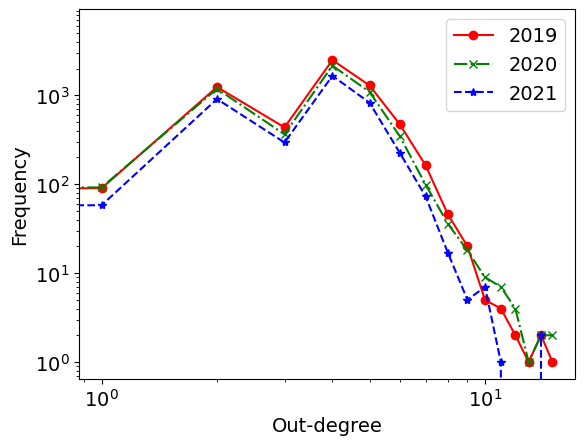

In [ ]:
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], out_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, styles[i], label=i)
plt.legend(loc="upper right")
plt.xlabel('Out-degree')
plt.ylabel('Frequency')

Are there HUBS available?

In [ ]:
for i in ['2019']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network 2019 Hubs:
[(rdflib.term.URIRef('http://local/local.owl#fact_that_rdf_graph_be_often_therefore_only_accessible_via_query'), 0.00021630580184756398), (rdflib.term.URIRef('http://local/local.owl#make_knowledge_graph_available_in_multiple_language_most_knowledge_graph_be_in_english'), 0.00021552265531568128), (rdflib.term.URIRef('http://local/local.owl#rdf_knowledge_graph'), 0.00021547971586069323), (rdflib.term.URIRef('http://local/local.owl#data_knowledge_graph'), 0.00021547971586069323), (rdflib.term.URIRef('http://local/local.owl#current_knowledge_graph'), 0.00021547971586069323), (rdflib.term.URIRef('http://local/local.owl#knowledge_graph_graph'), 0.00021547971586069323), (rdflib.term.URIRef('http://local/local.owl#information_knowledge_graph'), 0.00021547971586069323), (rdflib.term.URIRef('http://local/local.owl#dbpedia_knowledge_graph'), 0.00021547971586069323), (rdflib.term.URIRef('http://local/local.owl#target_knowledge_graph'), 0.00021547971586069323), (rdflib.term.URIRe

In [ ]:
for i in ['2020']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network 2020 Hubs:
[(rdflib.term.URIRef('http://local/local.owl#structure_of_a_the_entity_of_a_knowledge_base_the_hyperlink_graph_of_the_graph_of_an_rdf_the_entity_of_a_knowledge_base_and_basekb_to_benefit_from_the_precise_semantics_of_relationship_between_entity'), 0.000252287009186075), (rdflib.term.URIRef('http://local/local.owl#structure_of_a_the_entity_of_a_knowledge_base_the_hyperlink_graph_of_the_graph_of_an_rdf_the_entity_of_a_knowledge_base_and_yago_to_benefit_from_the_precise_semantics_of_relationship_between_entity'), 0.000252287009186075), (rdflib.term.URIRef('http://local/local.owl#recent_mainstream_solution_for_the_problem_of_structurebased_entity_alignment_between_knowledge_graph_apply_knowledge_graph_embed_technique_to_map_entity_into_a_vector_space_where_the_similarity_between_entity'), 0.00025058475239730964), (rdflib.term.URIRef('http://local/local.owl#global_score_with_important_property_a_novel_rdfbased_entity_relatedness_measure_for_global_score_have_a_clear_seman

In [ ]:
for i in ['2021']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network 2021 Hubs:
[(rdflib.term.URIRef('http://local/local.owl#we_exist_knowledge_in_wikidata_to_construct_a_graph_of_possible_relationship_in_the_table'), 0.00032446530029142846), (rdflib.term.URIRef('http://local/local.owl#we_exist_knowledge_in_wikidata_to_construct_a_graph_of_possible_relationship_in_the_table_context'), 0.0003234881329721544), (rdflib.term.URIRef('http://local/local.owl#result_complexity_of_validate_property_graph_against_set_of_progs_shape_compare_with_correspond_result_for_shaclfor_many_year_link_prediction_on_knowledge_graph_have_be_a_purely_transductive_task_not_allow_for_reason_on_unseen_entity'), 0.00032249650712920714), (rdflib.term.URIRef('http://local/local.owl#investigate_the_result_complexity_of_validate_property_graph_against_set_of_progs_shape_compare_with_correspond_result_for_shaclfor_many_year_link_prediction_on_knowledge_graph_have_be_a_purely_transductive_task_not_allow_for_reason_on_unseen_entity'), 0.00032249650712920714), (rdflib.term.URIRef('

# Communities

Check for communities using the Clauset-Newman-Moore Algorithm (greedy modularity - applicable to directed graphs)

In [ ]:
for k in TKG:
    comms = nx.community.greedy_modularity_communities(TKG[k])

    print(f'Network {k} -- Found {len(comms)} communities.')
    idx = 0
    for i in comms:
        print(f'Community {idx} has {len(i)} nodes.')
        #print(i)
        idx = idx + 1

Network 2019 -- Found 75 communities.
Community 0 has 2067 nodes.
Community 1 has 1549 nodes.
Community 2 has 769 nodes.
Community 3 has 767 nodes.
Community 4 has 538 nodes.
Community 5 has 487 nodes.
Community 6 has 484 nodes.
Community 7 has 433 nodes.
Community 8 has 397 nodes.
Community 9 has 373 nodes.
Community 10 has 348 nodes.
Community 11 has 245 nodes.
Community 12 has 219 nodes.
Community 13 has 213 nodes.
Community 14 has 210 nodes.
Community 15 has 209 nodes.
Community 16 has 208 nodes.
Community 17 has 188 nodes.
Community 18 has 183 nodes.
Community 19 has 167 nodes.
Community 20 has 160 nodes.
Community 21 has 149 nodes.
Community 22 has 144 nodes.
Community 23 has 144 nodes.
Community 24 has 140 nodes.
Community 25 has 138 nodes.
Community 26 has 121 nodes.
Community 27 has 119 nodes.
Community 28 has 116 nodes.
Community 29 has 116 nodes.
Community 30 has 112 nodes.
Community 31 has 97 nodes.
Community 32 has 88 nodes.
Community 33 has 87 nodes.
Community 34 has 49 n

# Small-world networks

Does it have a low average shortest path?

In [ ]:
for i in TKG:
    if nx.is_strongly_connected(TKG[i]):
        print(f'Network {i} -- Average shortest path length: {nx.average_shortest_path_length(TKG[i])}')
    else:
        print(f'Network {i} is NOT strongly connected!')

Network 2019 is NOT strongly connected!
Network 2020 is NOT strongly connected!
Network 2021 is NOT strongly connected!


Does it have a high clustering coefficient?

In [ ]:
for i in TKG:
    # create weighted graph from M, as method is not implemented for MultiDiGraphs
    DG = nx.DiGraph()
    for u,v in TKG[i].edges():
        if DG.has_edge(u,v):
            DG[u][v]['weight'] += 1
        else:
            DG.add_edge(u, v, weight=1)

    ccs = nx.clustering(DG,weight='weight').values()

    print(f"Network {i} -- Clustering coefficient: {sum(ccs)/len(ccs)}")

Network 2019 -- Clustering coefficient: 0.02860630905850965
Network 2020 -- Clustering coefficient: 0.029321244067005797
Network 2021 -- Clustering coefficient: 0.029230743136833815


# Some Centrality Measurements

NW 2019 DEGREE CENTRALITY
The mean degree centrality is 0.0003311135841256546, with stdev 0.0036839463158106953
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.39099641810485186
The minimum node is set of interest entity in knowledge graph, with value 8.140670791273201e-05
(0.39099641810485186, 0.11152718984044285, 0.010989905568218822, 0.01090849886030609, 0.008710517746662325, 0.00805926408336047, 0.007896450667535006, 0.006919570172582221, 0.006186909801367633, 0.005861282969716705, 0.005779876261803973, 0.005617062845978509, 0.005128622598502117, 0.004640182351025725, 0.004395962227287529, 0.004233148811462065, 0.0040703353956366, 0.0039075219798111365, 0.0038261152718984046, 0.0036633018560729407, 0.003581895148160209, 0.0035004884402474764, 0.0034190817323347445, 0.0033376750244220126, 0.0032562683165092807, 0.0031748616085965488, 0.0030120481927710845, 0.0029306414848583526, 0.0027678280690328883, 0.0026864213611201564, 0.0026050146532074245, 0

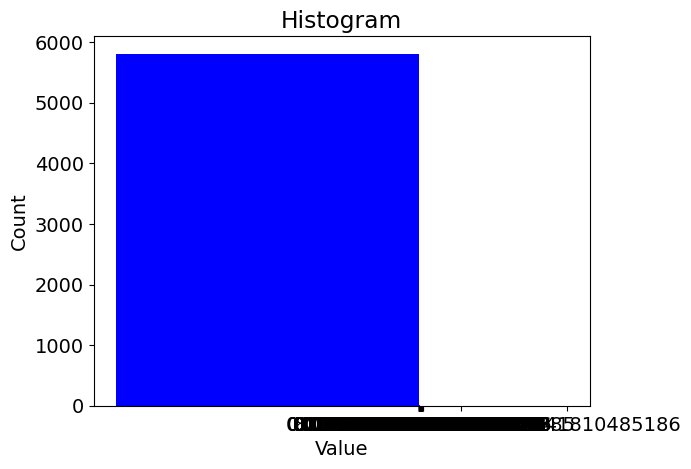


NW 2020 DEGREE CENTRALITY
The mean degree centrality is 0.0003751752862688485, with stdev 0.003991098988219094
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.39587454083074314
The minimum node is uninterpretable latent, with value 9.418856550814731e-05
(0.39587454083074314, 0.10530281623810869, 0.010266553640388056, 0.009230479419798437, 0.008947913723273995, 0.008382782330225111, 0.007629273806159932, 0.00734670810963549, 0.006593199585570312, 0.006310633889045869, 0.005839691061505133, 0.005745502495996986, 0.005651313930488839, 0.00489780540642366, 0.004803616840915513, 0.0044268625788829235, 0.0042384854478666285, 0.004144296882358482, 0.004050108316850334, 0.0038617311858340398, 0.003673354054817745, 0.0034849769238014506, 0.003390788358293303, 0.003296599792785156, 0.0032024112272770085, 0.0031082226617688614, 0.0029198455307525664, 0.0027314683997362718, 0.0026372798342281247, 0.002543091268719977, 0.00244890270321183, 0.0023547141377036826, 

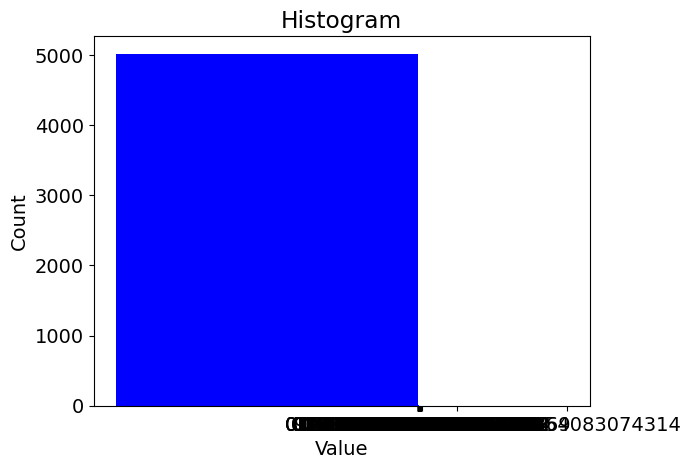


NW 2021 DEGREE CENTRALITY
The mean degree centrality is 0.0004894440515823329, with stdev 0.004653301358735987
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4025243689077731
The minimum node is answer freeform question, with value 0.00012496875781054737
(0.4025243689077731, 0.09922519370157462, 0.015621094726318422, 0.009497625593601601, 0.008372906773306673, 0.007498125468632842, 0.0067483129217695585, 0.006373406648337916, 0.005998500374906274, 0.0058735316170957265, 0.005623594101474632, 0.005498625343664084, 0.005373656585853537, 0.004623844038990253, 0.004498875281179706, 0.004373906523369158, 0.004248937765558611, 0.004123969007748063, 0.003999000249937516, 0.003749062734316421, 0.0036240939765058737, 0.0034991252186953262, 0.0033741564608847792, 0.003249187703074232, 0.0031242189452636844, 0.002999250187453137, 0.0028742814296425895, 0.002749312671832042, 0.0026243439140214947, 0.0024993751562109477, 0.0023744063984004003, 0.0022494376405898

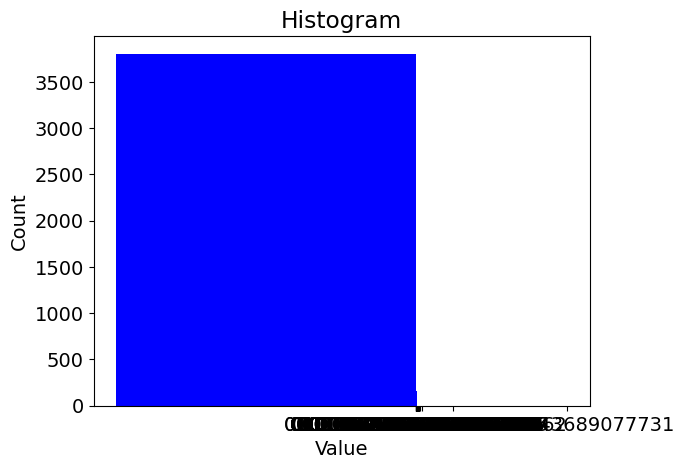


NW 2019 PAGERANK
The mean network pagerank is 8.140008140008321e-05, with stdev 0.0009797086290535121
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.10781943025845786
The minimum node is http://local/local.owl#s2019.33.4, with value 5.01001668057889e-05
(0.10781943025845786, 0.012358544054821155, 0.001578005961423059, 0.0014143511521272796, 0.001345470100707908, 0.001332773636968926, 0.0010641276904173925, 0.0010477560038174177, 0.0010449672876045697, 0.0010373767178696249, 0.0010096166222127209, 0.0010054503139896448, 0.0008626913082752282, 0.0008321228625478178, 0.000722785434810033, 0.0007190556821823725, 0.0007164510454440897, 0.0007063070649031427, 0.0006521405169615478, 0.0006512264552823012, 0.000645301010712732, 0.000618538024956393, 0.000603783971686337, 0.0006027838503344766, 0.0005980187381877913, 0.0005762323188243354, 0.0005647500180948582, 0.000536393110943069, 0.0005244005430487156, 0.0005049619733630431, 0.0005044286386599887, 0.0004

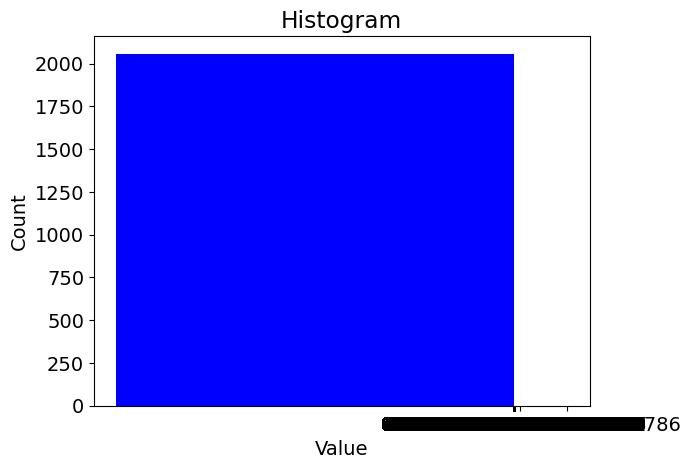


NW 2020 PAGERANK
The mean network pagerank is 9.417969485779077e-05, with stdev 0.0010665742108837003
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.10925135901643672
The minimum node is http://local/local.owl#s2020.211, with value 5.8237598871896834e-05
(0.10925135901643672, 0.011530611278769655, 0.001516631633631028, 0.0013704655423820039, 0.0013232705288880214, 0.0012817538902284626, 0.001256108471941213, 0.0012534085742516975, 0.0011514582647158737, 0.0010929341569274077, 0.0009536794893045417, 0.0008691893494484583, 0.0008524006766257259, 0.0007895908965862142, 0.0006981588594468757, 0.0006971428179018375, 0.0006830581913338166, 0.0006289312020916044, 0.0006258190656433139, 0.0006086704408638872, 0.0006012783175413237, 0.0006006157108949709, 0.0005987440806446208, 0.0005898797957242462, 0.0005874601064749331, 0.0005872616321457338, 0.000572041786169795, 0.0005719666060106015, 0.0005541543160819402, 0.0005404036238614695, 0.0005367313650320862, 

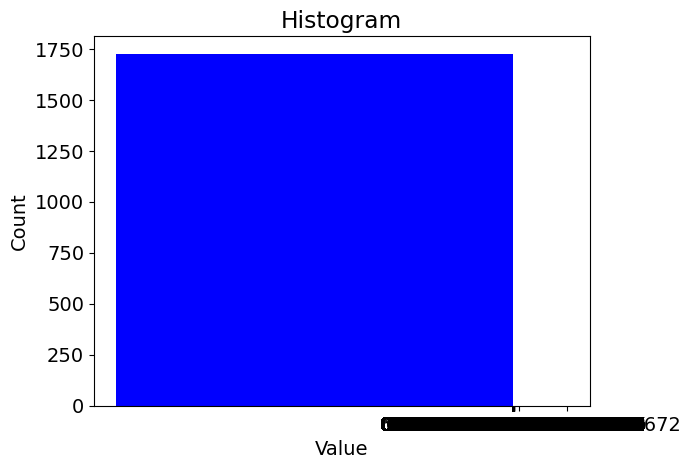


NW 2021 PAGERANK
The mean network pagerank is 0.00012495314257154148, with stdev 0.0012422676075014556
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.11057456918704886
The minimum node is http://local/local.owl#keyvalue_annotation_to_nod_to_edge, with value 7.736701496726654e-05
(0.11057456918704886, 0.010916354844850025, 0.0015549494935621557, 0.0015430071235156897, 0.0013455707417106026, 0.001326746429063002, 0.0011905919666860632, 0.0011593772183663218, 0.0010593701242086417, 0.0010002788172951773, 0.0008873610429962437, 0.0008466241878415576, 0.0008274286242516785, 0.000790290092056654, 0.0007749255552662235, 0.0007396208527047434, 0.0007359578688992606, 0.0007246888850967753, 0.0007074911326308823, 0.0006734668308589743, 0.0006480796633734368, 0.0006436398529662642, 0.0006311691821366131, 0.0006255162035725154, 0.0006145453313632522, 0.0006035775292766942, 0.0005910123026921137, 0.0005713517935293672, 0.0005700588541027018, 0.000559473915662447

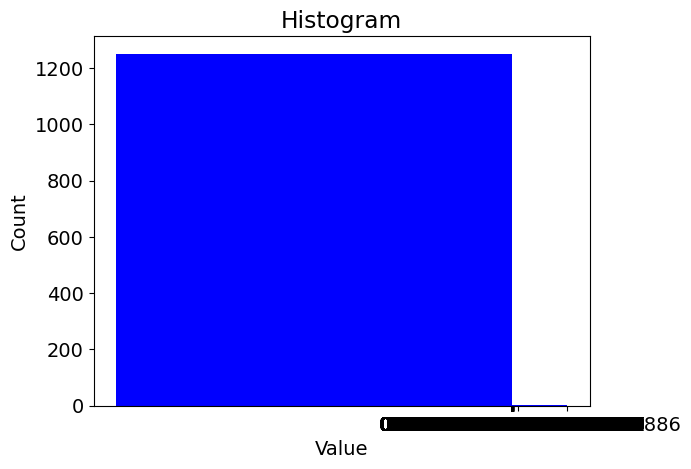


NW 2019 BETWEENNESS CENTRALITY
The mean betwenness centrality is 5.984685564357358e-08, with stdev 1.8478159574953157e-07
The maximum node is http://local/local.owl#knowledge_graph, with value 8.50485695099026e-06
The minimum node is http://local/local.owl#s2019.33.4, with value 0.0
(8.50485695099026e-06, 5.202659424529401e-06, 3.910279057926556e-06, 3.697091527367283e-06, 3.5059959688866916e-06, 3.1481060212120578e-06, 2.599120515056832e-06, 2.5847607332056896e-06, 2.3859329844975595e-06, 2.2522765534215386e-06, 2.221347792511385e-06, 2.014787853575717e-06, 1.948511937339674e-06, 1.8722946336682243e-06, 1.8524118587974109e-06, 1.654688708693215e-06, 1.652479511485347e-06, 1.634253634520435e-06, 1.6232076484810944e-06, 1.5475426441116117e-06, 1.5265552706368645e-06, 1.480714428573601e-06, 1.4713253404401617e-06, 1.4315597906985358e-06, 1.4083632200159205e-06, 1.3873758465411735e-06, 1.3680453709723274e-06, 1.3586562828388881e-06, 1.3155769372854599e-06, 1.3122631414736578e-06, 1.27912

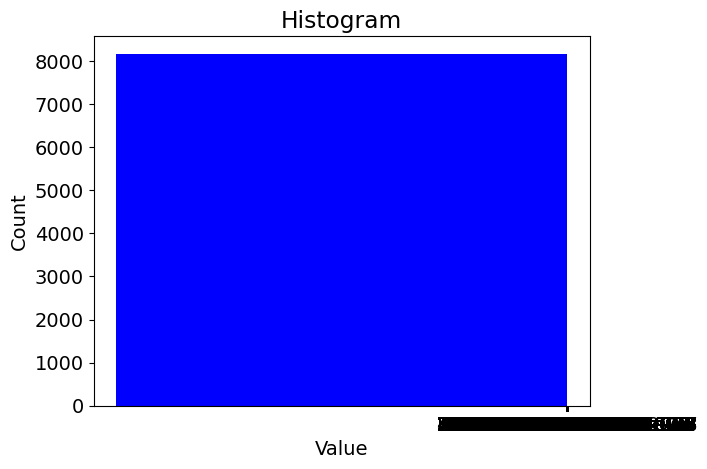


NW 2020 BETWEENNESS CENTRALITY
The mean betwenness centrality is 7.748783820262437e-08, with stdev 2.2830771685695208e-07
The maximum node is http://local/local.owl#knowledge_graph, with value 7.85658859899111e-06
The minimum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.0
(7.85658859899111e-06, 4.524883987297959e-06, 4.028033980849556e-06, 3.875725794349004e-06, 3.6642687975569746e-06, 3.5252690933720045e-06, 2.9515256335446813e-06, 2.9234299486562303e-06, 2.901418141397759e-06, 2.771121762155678e-06, 2.7592920000973827e-06, 2.617334855397839e-06, 2.497558514557599e-06, 2.490904273399808e-06, 2.374824733202785e-06, 2.306803601367587e-06, 2.235825029017815e-06, 2.218080385930372e-06, 2.1559741351243216e-06, 2.112647631585815e-06, 2.076123241230828e-06, 2.0702083602016806e-06, 2.064293479172533e-06, 2.053731191620484e-06, 2.0347190740267947e-06, 1.9874000257936133e-06, 1.9164214534438416e-06, 1.8683630450820166e-06, 1.8129110354337573e-06, 1.7626345466860025e-0

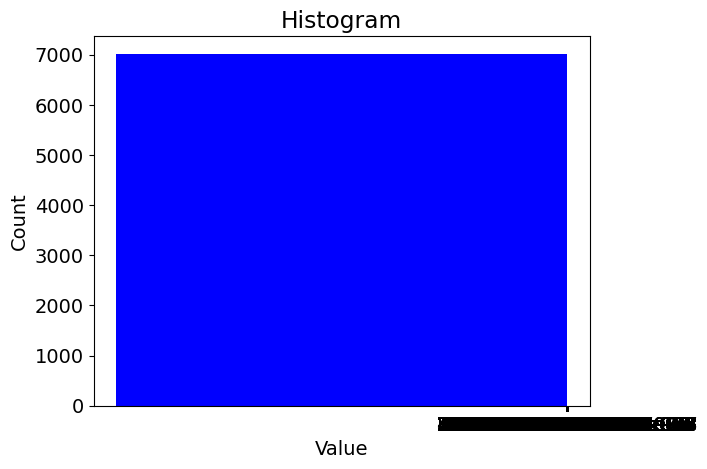


NW 2021 BETWEENNESS CENTRALITY
The mean betwenness centrality is 1.3783800405443667e-07, with stdev 3.8600499768259586e-07
The maximum node is http://local/local.owl#largest_open_collaborative_knowledge_base, with value 8.844339346359508e-06
The minimum node is http://local/local.owl#keyvalue_annotation_to_nod_to_edge, with value 0.0
(8.844339346359508e-06, 7.929317924653737e-06, 6.450705783746539e-06, 6.178412069065389e-06, 5.690574190181572e-06, 5.510954053346014e-06, 5.352159439621826e-06, 5.341746678066142e-06, 5.0762212583961866e-06, 4.719584175113992e-06, 4.592027846056859e-06, 4.498312992055698e-06, 4.253613095497112e-06, 3.7017367330458344e-06, 3.5325293577659614e-06, 3.29563903237414e-06, 3.280019890040613e-06, 3.11081251476074e-06, 3.0457327550377123e-06, 2.9572242818143935e-06, 2.9520179010365515e-06, 2.8478902854797066e-06, 2.8348743335351013e-06, 2.7489690507007042e-06, 2.74350235088397e-06, 2.7177307660336508e-06, 2.6526510063106226e-06, 2.6409366495604777e-06, 2.5875712

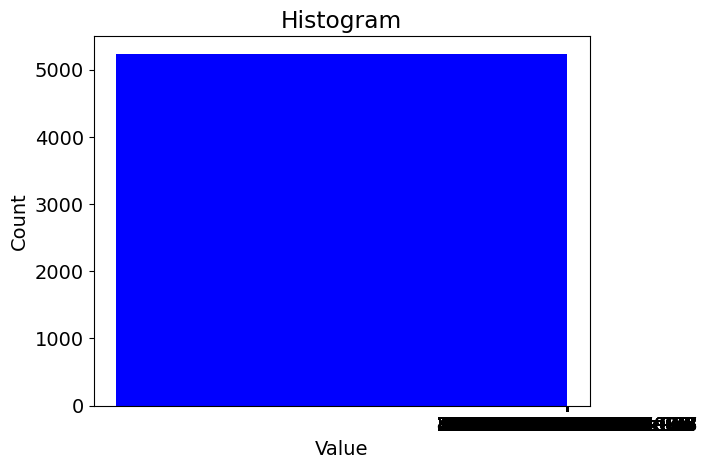

In [ ]:
for i in TKG:
    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(TKG[i])
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print(f"NW {i} DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()

for i in TKG:
    # PageRank -- mean and stdev
    pc = nx.pagerank(TKG[i])
    degrees = []
    for k,v in pc.items():
        degrees.append(v)

    print(f"NW {i} PAGERANK")
    print("======================")
    print("The mean network pagerank is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(pc, key=pc.get), max(pc.values())))
    print("The minimum node is {}, with value {}".format(min(pc, key=pc.get), min(pc.values())))
    histogram(pc)
    print()

for i in TKG:
    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(TKG[i])
    degrees = []
    for k,v in bc.items():
        degrees.append(v)

    print(f"NW {i} BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()